# HILO Notebook

This notebook gives examples of how to use the provided modules:
- Phosphene model
- Deep stimulus encoder
- Human in the loop optimization

Before running, please read the installation instructions in the readme, and install the requirements.


## Phosphene Model

The phosphene model is implemented in pulse2percept, an open source python library. We also provide a tensorflow equivalent,
but the pulse2percept version is much more user friendly.

In [1]:
import pulse2percept as p2p
from src.phosphene_model import RectangleImplant, MVGModel

In [2]:
!pip freeze

absl-py==2.3.1
anyio==4.12.1
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
arrow==1.4.0
asttokens==3.0.1
astunparse==1.6.3
async-lru==2.1.0
attrs==25.4.0
babel==2.17.0
beautifulsoup4==4.14.3
bleach==6.3.0
botorch==0.16.1
certifi==2026.1.4
cffi==2.0.0
charset-normalizer==3.4.4
comm==0.2.3
contourpy==1.3.2
cycler==0.12.1
Cython==3.2.4
debugpy==1.8.19
decorator==5.2.1
defusedxml==0.7.1
exceptiongroup==1.3.1
executing==2.2.1
fastjsonschema==2.21.2
filelock==3.20.3
flatbuffers==25.12.19
fonttools==4.61.1
fqdn==1.5.1
fsspec==2026.1.0
gast==0.4.0
google-auth==2.47.0
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
gpytorch==1.15.1
grpcio==1.76.0
h11==0.16.0
h5py==3.15.1
httpcore==1.0.9
httpx==0.28.1
idna==3.11
ImageIO==2.37.2
imageio-ffmpeg==0.6.0
ipykernel==7.1.0
ipython==8.38.0
ipywidgets==8.1.8
isoduration==20.11.0
jax==0.4.30
jaxlib==0.4.30
jaxtyping==0.3.5
jedi==0.19.2
Jinja2==3.1.6
joblib==1.5.3
json5==0.13.0
jsonpointer==3.0.0
jsonschema==4.26.0
jsonschema-specifications==2025.9.1
ju

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

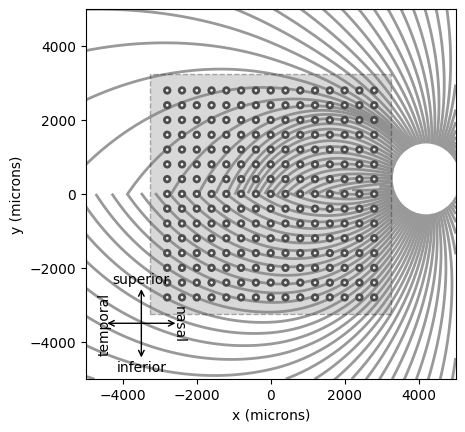

In [3]:
implant = RectangleImplant()
# MultiVariateGaussian model
model = MVGModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.25).build()
implant.plot()
model.plot()

All stimuli to this model must be biphasic pulse trains. Here is an example of how the model can be used to predict the percept resulting from stimulation on every 6th electrode.

<Axes: xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

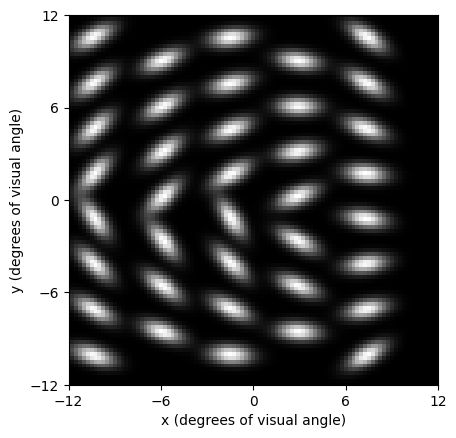

In [4]:
implant.stim = {e : p2p.stimuli.BiphasicPulseTrain(20, 2, 0.45) for e in implant.electrode_names[::6]}
percept = model.predict_percept(implant)
percept.plot()

The model responds to changes in both patient-specific parameters (e.g. rho, a0; passed to model or implant) or stimulus parameters 

<Axes: xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

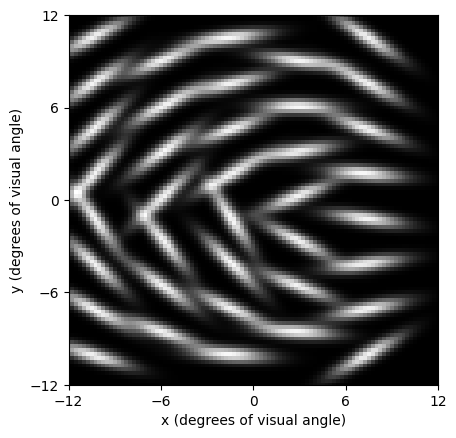

In [5]:
# Stimulus parameters
implant.stim = {e : p2p.stimuli.BiphasicPulseTrain(120, 3, 0.3) for e in implant.electrode_names[::6]}
model.predict_percept(implant).plot()

<Axes: xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

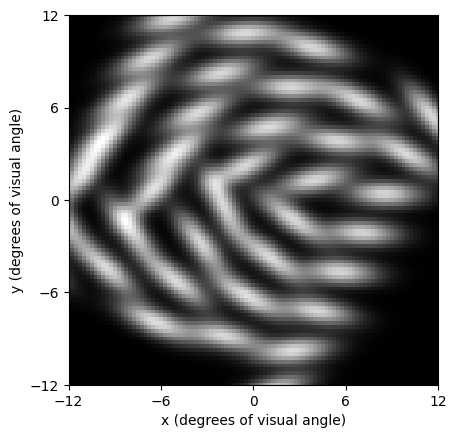

In [6]:
# patient-specific parameters
implant = RectangleImplant(rot=30)
model = MVGModel(lam=0.94, rho=200, xrange=(-12, 12), yrange=(-12, 12), xystep=0.25).build()
implant.stim = {e : p2p.stimuli.BiphasicPulseTrain(20, 2, 0.45) for e in implant.electrode_names[::6]}
model.predict_percept(implant).plot()

## Deep stimulus encoder

Here we provide an example for how to load the DSE and how to use it to make predictions

In [7]:
import os
# ignore 1 million tensorflow warnings, comment out if you run into errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from src.phosphene_model import RectangleImplant, MVGModel
from src.DSE import fetch_dse, load_mnist, rand_model_params

In [8]:
version = 'v2' # version from paper, with bug fixed.
# load the dse neural network
# modelpath = './assets/dse'
implant = RectangleImplant()
model = MVGModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.5).build()
dse = fetch_dse(model, implant, version=version)

# load mnist targets and random set of patient-specific parameters
(targets, labels), (targets_test, labels_test) = load_mnist(model)
phi = rand_model_params(len(targets_test), version=version)

In [9]:
dse.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phi_input (InputLayer)         [(None, 13)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 13)          52          ['phi_input[0][0]']              
 alization)                                                                                       
                                                                                                  
 dense_1 (Dense)                (None, 1024)         14336       ['batch_normalization[0][0]']    
                                                                                                  
 dense_2 (Dense)                (None, 1024)         1049600     ['dense_1[0][0]']          

A set of random patient-specific parameters, smapled from the ranges specified in the paper, are now stored in phi. 


We can evaluate the MNIST test set over this random set of patients. Note that the exact value may vary slightly from that in the paper, since the new phi is random 

**EDIT** 

We have updated the model to correct a small bug in the original with patient parameter a4. This version performs slightly better than reported in the paper

In [10]:
# dse.evaluate((targets_test, phi), targets_test)
pass

We can also view the predicted stimuli for a few targets and patients. 

Note that the provided both 1) predicts stimuli and 2) decodes those stimuli according to each patients phosphene model, parameterized by its ground truth phi. If you want to just get predictions, you can remove the last layer of the network, as is done later in HILO optimization.

2026-01-20 11:08:12.801209: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator StatefulPartitionedCall/StatefulPartitionedCall/assert_equal_1/Assert/Assert
2026-01-20 11:08:12.917291: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator StatefulPartitionedCall/StatefulPartitionedCall/assert_greater_equal/Assert/Assert
2026-01-20 11:08:12.917401: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator StatefulPartitionedCall/StatefulPartitionedCall/assert_greater_equal_1/Assert/Assert
2026-01-20 11:08:12.917433: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator StatefulPartitionedCall/StatefulPartitionedCall/assert_equal_3/Assert/Assert
2026-01-20 11:08:12.917621: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator StatefulPartitionedCall/StatefulPartitionedCall/assert_equal_5/Assert/Assert


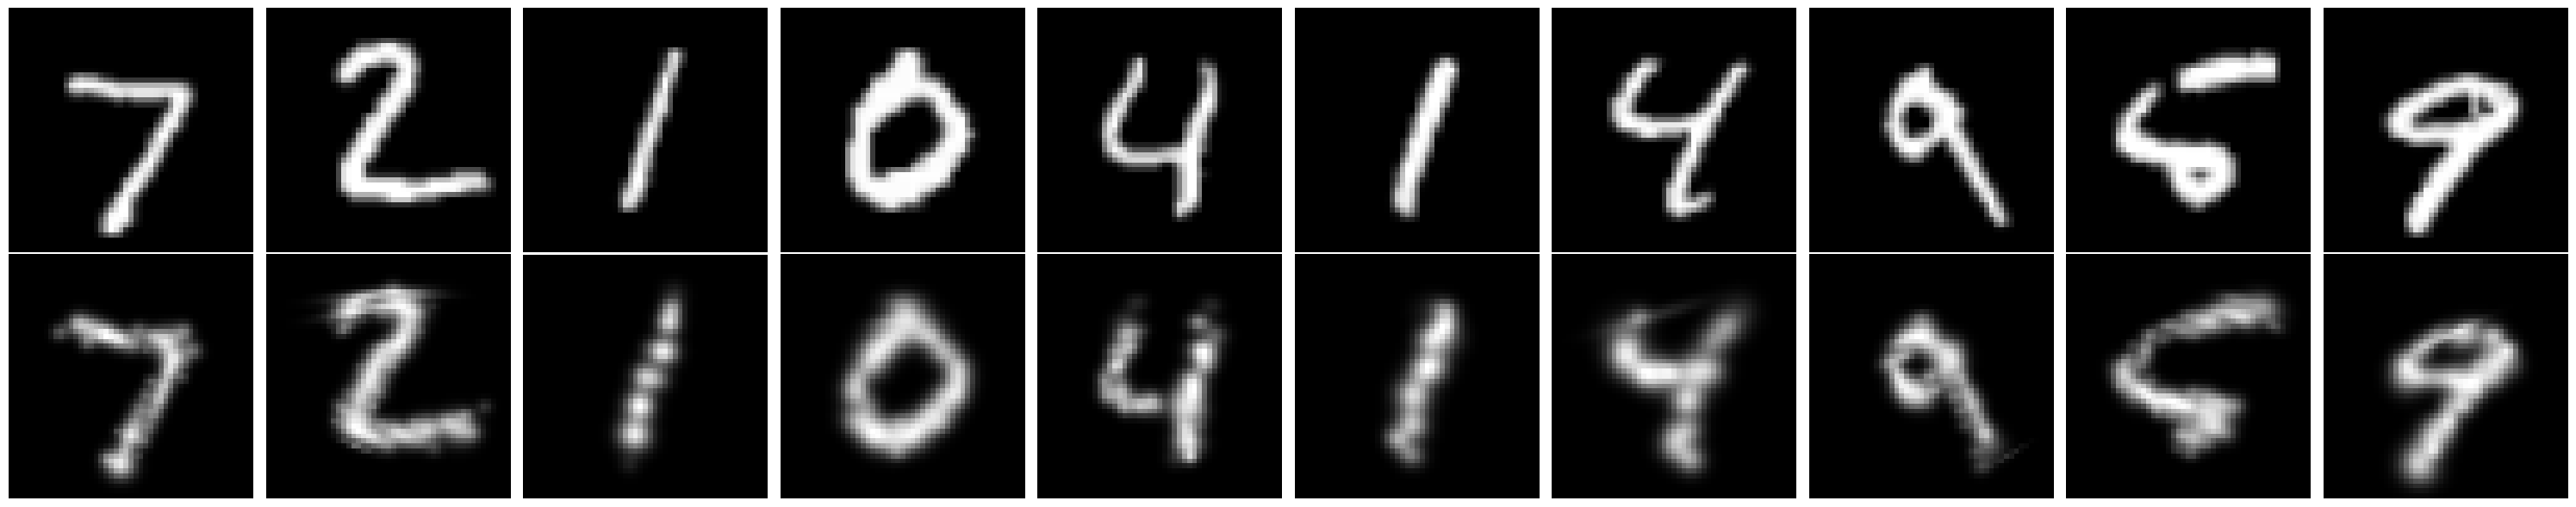

In [11]:
nimgs = 10
predicted_percepts = dse([targets_test[:nimgs], phi[:nimgs]])
fig, axes = plt.subplots(2, nimgs, figsize=(nimgs*3, 6))
for idx, (pred, target) in enumerate(zip(predicted_percepts, targets_test[:nimgs])): 
    axes[0, idx].imshow(target, cmap='gray')
    axes[1, idx].imshow(pred, cmap='gray')
# make it look nice
for ax in axes.ravel():
    ax.axis('off')
fig.tight_layout()

Again, note that these are encoded using the ground-truth patient-specific parameters, which would not be known in the wild.

## Human-in-the-Loop Optimization

Here, we show an example of how to use HILO with simulated patients. 

Note that Bayesian optimization uses Matlab. Thus you must have Matlab and the Matlab python extension installed, which must be installed separately from requirements.txt (see readme)

In [12]:
import os
# ignore 1 million tensorflow warnings, comment out if you run into errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.phosphene_model import RectangleImplant, MVGModel
from src.DSE import load_mnist, rand_model_params, fetch_dse
from src.HILO import HILOPatient, patient_from_phi_arr

In [13]:
# setup
version='v2' # version from paper, with bug fixed.
np.random.seed(42)
implant = RectangleImplant()
model = MVGModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.5).build()
dse = fetch_dse(model, implant, version=version)
(targets, labels), (targets_test, labels_test) = load_mnist(model)
phis = rand_model_params(len(targets_test), version=version)

# run for the first patient
phi = phis[0]
matlab_dir = 'matlab/'
# get a true model corresponding to the patient specified by phi
model, implant = patient_from_phi_arr(phi, model, implant, implant_kwargs={})
patient = HILOPatient(model, implant, dse=dse, phi_true=phi, matlab_dir=matlab_dir, version=version)

The following function runs HILO optimization on a patient for n duels

In [14]:
def run_hilo(patient, num_duels):
    d = patient.d
    xtrain = np.empty((d*2, num_duels), dtype='double') # phi1/phi2 used in duels
    ctrain = np.empty((num_duels), dtype='double') # responses
    losses = []
    
    pbar = tqdm(range(num_duels), unit='duels')
    for idx_duel in pbar:
        if idx_duel == 0:
            xtrain[:, idx_duel] = patient.hilo_acquisition(None, None)
        else:
            xtrain[:, idx_duel] = patient.hilo_acquisition(xtrain[:, :idx_duel], ctrain[:idx_duel])
        phi1 = xtrain[:d, idx_duel]
        phi2 = xtrain[d:, idx_duel]

        target = targets_test[np.random.randint(0, len(targets_test))] # get a random target
        # simulate the duel
        decision, resdict = patient.duel(target, phi1, phi2)
        ctrain[idx_duel] = decision
        # update posterior
        patient.hilo_update_posterior(xtrain[:, :idx_duel+1], ctrain[:idx_duel+1])
        # get the current best guess for true phi
        phi_guess = patient.hilo_identify_best(xtrain[:, :idx_duel+1], ctrain[:idx_duel+1])
        
        # for example here, only evaluate on subset of test set to save time
        nsamples = 256 * 4
        dse_loss = patient.mismatch_dse.evaluate(x=[targets_test[:nsamples], tf.repeat(phi_guess[None, ...], nsamples, axis=0)], 
                                                 y=targets_test[:nsamples], batch_size=256, verbose=0)
        losses.append(dse_loss)
        pbar.set_description(f"loss: {dse_loss : .4f}")
    return phi_guess, losses

Now we can run the patient. This can take a while, mainly due to evaluating the DSE loss at every iteration, but also due to running the acquisition function for new $\phi$. The loss might not change for a number of duels. This is because HILO is exploring new candidate phi, but often this exploration takes a while to be fruitful (up to ~20 duels).

In [16]:
# best_phi, losses = run_hilo(patient, 100)
best_phi, losses = run_hilo(patient, 20)

  0%|          | 0/20 [00:00<?, ?duels/s]

ValueError: shape mismatch: value array of shape (13,13) could not be broadcast to indexing result of shape (13,)

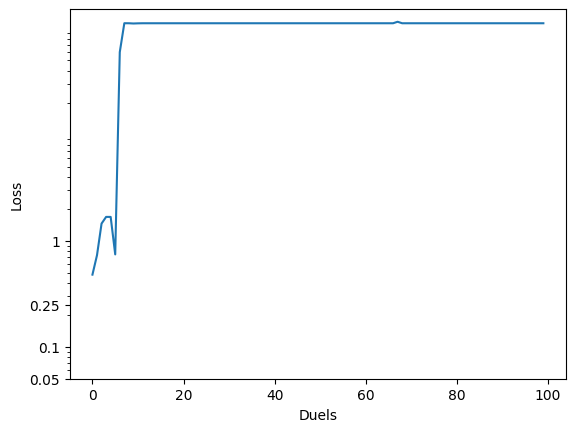

In [16]:
# view the results
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Duels")
plt.ylabel("Loss")
plt.yscale('log')
plt.yticks([0.05, 0.1, 0.25, 1], labels =[str(i) for i in [0.05, 0.1, 0.25, 1]])
plt.show()

We can use the patients mismatch_dse to view the resulting percepts, encoded with our best guess for phi

2026-01-20 10:40:53.329212: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator UniversalMVG/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/assert_equal_1/Assert/Assert
2026-01-20 10:40:53.419006: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator UniversalMVG/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/assert_greater_equal/Assert/Assert
2026-01-20 10:40:53.419102: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator UniversalMVG/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/assert_greater_equal_1/Assert/Assert
2026-01-20 10:40:53.419124: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator UniversalMVG/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/assert_equal_3/Assert/Assert
2026-01-20 10:40:53.419167: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert oper

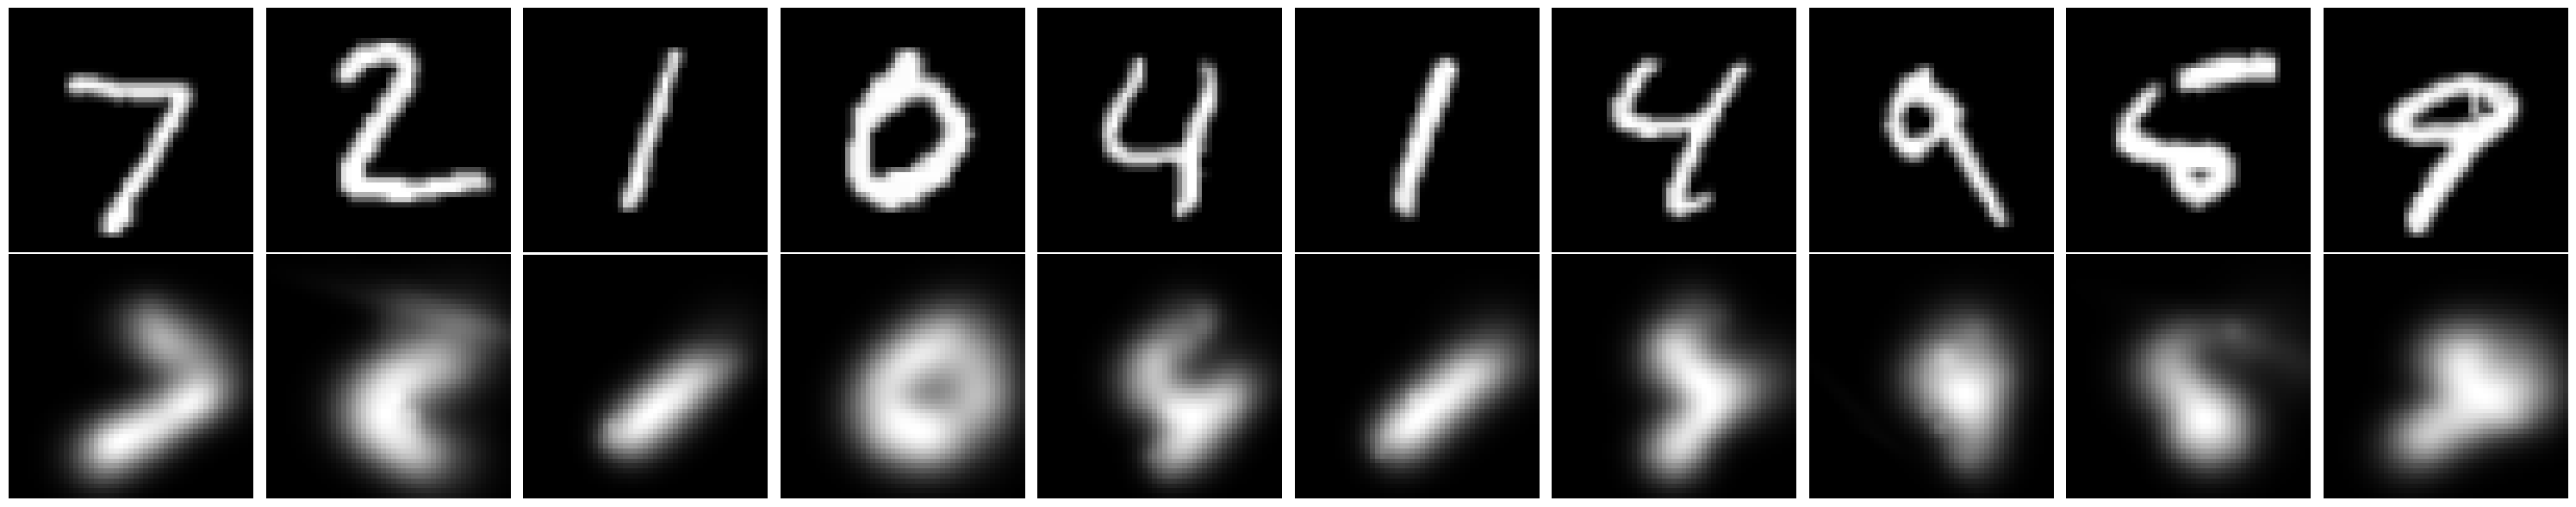

In [17]:
nimgs = 10
predicted_percepts = patient.mismatch_dse([targets_test[:nimgs], tf.repeat(best_phi[None, ...], nimgs, axis=0)])
fig, axes = plt.subplots(2, nimgs, figsize=(nimgs*3, 6))
for idx, (pred, target) in enumerate(zip(predicted_percepts, targets_test[:nimgs])): 
    axes[0, idx].imshow(target, cmap='gray')
    axes[1, idx].imshow(pred, cmap='gray')
# make it look nice
for ax in axes.ravel():
    ax.axis('off')
fig.tight_layout()

In [ ]:
@inproceedings{user_guided_bo,
  title     = {A General Framework for User-Guided Bayesian Optimization},
  author    = {['Carl Hvarfner', 'Frank Hutter', 'Luigi Nardi']},
  booktitle = {International Conference on Learning Representations},
  year      = {2023}
}
@inproceedings{hil_dse,
  title     = {Human-in-the-Loop Optimization for Deep Stimulus Encoding in Visual Prostheses},
  author    = {['Jacob Granley', 'T. Fauvel', 'M. Chalk', 'M. Beyeler']},
  booktitle = {Neural Information Processing Systems},
  year      = {2023}
}
@inproceedings{adachi_bo,
  title     = {Looping in the Human: Collaborative and Explainable Bayesian Optimization},
  author    = {['Masaki Adachi', 'Brady Planden', 'David A. Howey', 'Krikamol Maundet', 'Michael A. Osborne', 'Siu Lun Chau']},
  booktitle = {International Conference on Artificial Intelligence and Statistics},
  year      = {2023}
}
@inproceedings{mobo_apl,
  title     = {Multi-Objective Bayesian Optimization with Active Preference Learning},
  author    = {['Ryota Ozaki', 'Kazuki Ishikawa', 'Youhei Kanzaki', 'Shinya Suzuki', 'Shion Takeno', 'Ichiro Takeuchi', 'Masayuki Karasuyama']},
  booktitle = {AAAI Conference on Artificial Intelligence},
  year      = {2023}
}
@inproceedings{pub_mobo,
  title     = {Preferential Multi-Objective Bayesian Optimization},
  author    = {['Raul Astudillo', 'Kejun Li', 'Maegan Tucker', 'Chu Xin Cheng', 'A. D. Ames', 'Yisong Yue']},
  booktitle = {Trans. Mach. Learn. Res.},
  year      = {2024}
}
@inproceedings{cpbo,
  title     = {Consecutive Preferential Bayesian Optimization},
  author    = {['A. Erarslan', 'Carlos Sevilla Salcedo', 'Ville Tanskanen', 'A. Nisov', 'Eero Paivakumpu', 'Heikki Aisala', 'Kaisu Honkapaa', 'Arto Klami', 'P. Mikkola']},
  booktitle = {arXiv.org},
  year      = {2025}
}
@inproceedings{lilo,
  title     = {LILO: Bayesian Optimization with Interactive Natural Language Feedback},
  author    = {['Katarzyna Kobalczyk', 'Zhiyuan Jerry Lin', 'Ben Letham', 'Zhuokai Zhao', 'M. Balandat', 'E. Bakshy']},
  booktitle = {arXiv.org},
  year      = {2025}
}
@inproceedings{user_preference_meets_pareto,
  title     = {User Preference Meets Pareto-Optimality in Multi-Objective Bayesian Optimization},
  author    = {['Joshua Hang Sai Ip', 'Ankush Chakrabarty', 'Ali Mesbah', 'Diego Romeres']},
  booktitle = {AAAI Conference on Artificial Intelligence},
  year      = {2025}
}